# Store items recommendation system

In today's data-driven landscape, businesses are increasingly turning to data science and machine learning to gain competitive advantages and drive innovation. This document delves into key methodologies and practical applications discussed, including data preprocessing, exploratory data analysis (EDA), and advanced machine learning techniques. From optimizing data quality with Pandas to visualizing trends using Matplotlib, and employing sophisticated models like BERT for recommendation engines, we explore how these tools enable businesses to extract actionable insights. By embracing these methodologies, organizations can enhance decision-making, personalize customer experiences, and uncover new opportunities in a rapidly evolving market. This introduction sets the stage for an in-depth exploration of how data-driven strategies can empower businesses to thrive in the digital age.


Recommendation engine types:

- Collaborative filtering (behavioral clustering) - relies on user behavior and preferences to recommend items. It assumes that users who agreed in the past will agree in the future and that they will like similar kinds of items that they liked in the past.
- Content-based filtering - recommends items based on the features of the items and a profile of the user’s preferences. It uses item features (e.g., tags, categories, pricing, and other ) and compares them to the user's past preferences.
- Hybrid recommendation engines - combine collaborative filtering and content-based filtering to leverage the strengths of both methods. They aim to provide more accurate and comprehensive recommendations and it helps to suggest a similar or close item to the users.


We chose content-based filtering:

- No dependency on user behavior - Content-based filtering does not require data on other users’ preferences or behavior, making it useful in scenarios where user interaction data is sparse or unavailable.
- Personalization - It provides highly personalized recommendations based on the specific interests and preferences of individual users, utilizing detailed item features and characteristics.
- Handling of new items - It effectively addresses the cold start problem by recommending new items based on their intrinsic features, even if they have no or limited interaction history.


## Data preparation

In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt


In [ ]:

file_path_1="......."
file_path_2="......."

In [ ]:
# Load the dataset with dask
df = pd.read_csv(file_path_1)
wgi_descr = pd.read_csv(file_path_2)
wgi_descr.rename(columns={'ARTICLE_ID': 'article_id'}, inplace=True)


In [3]:
from google.colab import drive 
drive.mount('/content/drive')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Mounted at /content/drive


In [4]:
import pandas as pd
data_cleaned = pd.read_csv('data_sample.csv') 

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Display the first few rows
print(df.head())
print(wgi_descr.head())



                   bon_id              customer  article_id  price    qty  \
0  /M+24Ty4omsvXxkYpDi5Mg  448da7e87cfe2351ea1c       70145   5.24  1.000   
1  0bqzmS9FZKWKbuixrZt//Q  2d1a4bc8e19ac46e4896     3901219   1.10  1.000   
2  A5+2lZ5gskhsEFHAntHMKA  3e23aeed1f216b5969c2       30015   3.29  1.000   
3  RuoOGVsbqEqSsbNPbyltSg  b443a742d956cf281193      300894   7.00  0.826   
4  fCVxkNOtQ75uGWrq8DJoLg  aefc75b928e7268f32a0       31728   1.19  1.000   

  unit  article_mother     wgi            date_time  
0   ST             NaN  257031  2019-02-25 20:29:02  
1   ST         10559.0  431012  2019-02-25 13:31:21  
2   ST             NaN  238012  2019-02-25 10:16:48  
3   KG             NaN  185003  2019-02-25 17:16:28  
4   ST             NaN  263008  2019-02-25 11:25:55  
   article_id     WGI           WGI_DESCRIPTION
0     9700113  163015              Кореноплодни
1     2401302  493003  Разтворимо кафе до 199 г
2       19847  143005          Маслини, пълнени
3      300431  185025

In [ ]:
# Merge both data frames
merged_data = pd.merge(df, wgi_descr, on = "article_id")


In [ ]:
merged_data.head()

,bon_id,customer,article_id,price,qty,unit,article_mother,wgi,date_time,WGI,WGI_DESCRIPTION
0,/M+24Ty4omsvXxkYpDi5Mg,448da7e87cfe2351ea1c,70145,5.24,1.000,ST,NaN,257031,2019-02-25 20:29:02,257031,To Go салати с вилица
1,0bqzmS9FZKWKbuixrZt//Q,2d1a4bc8e19ac46e4896,3901219,1.10,1.000,ST,10559.0,431012,2019-02-25 13:31:21,431012,Сладък червен пипер
2,A5+2lZ5gskhsEFHAntHMKA,3e23aeed1f216b5969c2,30015,3.29,1.000,ST,NaN,238012,2019-02-25 10:16:48,238012,"Луканки,Суджуци,Сушеници и др.-слайс"
3,RuoOGVsbqEqSsbNPbyltSg,b443a742d956cf281193,300894,7.00,0.826,KG,NaN,185003,2019-02-25 17:16:28,185003,SB Пилешки разфасовки с кост
4,fCVxkNOtQ75uGWrq8DJoLg,aefc75b928e7268f32a0,31728,1.19,1.000,ST,NaN,263008,2019-02-25 11:25:55,263008,Хейвер


In [ ]:
# check data types and the count of the non-null values
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3740259 entries, 0 to 3740258
Data columns (total 11 columns):
 #   Column           Dtype  
---  ------           -----  
 0   bon_id           object 
 1   customer         object 
 2   article_id       int64  
 3   price            float64
 4   qty              float64
 5   unit             object 
 6   article_mother   float64
 7   wgi              int64  
 8   date_time        object 
 9   WGI              int64  
 10  WGI_DESCRIPTION  object 
dtypes: float64(3), int64(3), object(5)
memory usage: 313.9+ MB


In [ ]:
# Check for duplicates and NA values
print(merged_data.columns) # 2 wgi columns
print(f'Number of duplicated records: {merged_data.duplicated().sum()}') # 1104597 duplicates
print(merged_data.isna().sum()) # article_mother has 2262151 NA values


Index(['bon_id', 'customer', 'article_id', 'price', 'qty', 'unit',
       'article_mother', 'wgi', 'date_time', 'WGI', 'WGI_DESCRIPTION'],
      dtype='object')
Number of duplicated records: 1104597
bon_id                   0
customer                 0
article_id               0
price                    0
qty                      0
unit                     0
article_mother     2262151
wgi                      0
date_time                0
WGI                      0
WGI_DESCRIPTION          0
dtype: int64


In [ ]:
# Remove duplicated values
merged_data = merged_data[~merged_data.duplicated()]

print(f'Number of duplicated records: {merged_data.duplicated().sum()}') # 0 duplicated records


Number of duplicated records: 0


In [ ]:
merged_data.shape

(2635662, 11)

In [ ]:
# Remove NA values
#data_cleaned = merged_data.dropna(subset=['article_mother'])
#print(data_cleaned.isna().sum())



In [ ]:
# Adjust data types
data_cleaned=merged_data.copy()
print(data_cleaned.dtypes)

bon_id              object
customer            object
article_id           int64
price              float64
qty                float64
unit                object
article_mother     float64
wgi                  int64
date_time           object
WGI                  int64
WGI_DESCRIPTION     object
dtype: object


In [ ]:
# Changing data types
data_cleaned['bon_id'] = data_cleaned['bon_id'].astype(str)
data_cleaned['customer'] = data_cleaned['customer'].astype(str)
data_cleaned['article_id'] = data_cleaned['article_id'].astype('int32')
data_cleaned['price'] = data_cleaned['price'].astype('float32')
data_cleaned['qty'] = data_cleaned['qty'].astype('float32')
data_cleaned['unit'] = data_cleaned['unit'].astype(str)
data_cleaned['article_mother'] = data_cleaned['article_mother'].fillna(0).astype('int32')
data_cleaned['wgi'] = data_cleaned['wgi'].astype('int32')
data_cleaned['date_time'] = pd.to_datetime(data_cleaned['date_time'])
data_cleaned['WGI'] = data_cleaned['WGI'].astype('int32')
data_cleaned['WGI_DESCRIPTION'] = data_cleaned['WGI_DESCRIPTION'].astype(str)

In [ ]:
print(data_cleaned.dtypes)

bon_id                     object
customer                   object
article_id                  int32
price                     float32
qty                       float32
unit                       object
article_mother              int32
wgi                         int32
date_time          datetime64[ns]
WGI                         int32
WGI_DESCRIPTION            object
dtype: object


In [ ]:
# check if the two wgi columns are identical
print(f"Number of unique values in wgi: {data_cleaned['wgi'].nunique()}")
print(f"Number of unique values in WGI: {data_cleaned['WGI'].nunique()}")
diff_wgi = 0
for i in range(len(data_cleaned)):
    if data_cleaned.iloc[i]['WGI'] != data_cleaned.iloc[i]['wgi']:
        diff_wgi+=1

print(diff_wgi)
if(diff_wgi == 0):
  data_cleaned.drop('WGI', axis=1, inplace=True)
print(data_cleaned.columns)


Number of unique values in wgi: 1719
Number of unique values in WGI: 1719
0
Index(['bon_id', 'customer', 'article_id', 'price', 'qty', 'unit',
       'article_mother', 'wgi', 'date_time', 'WGI_DESCRIPTION'],
      dtype='object')


In [ ]:
# Check for price < 0
negative_count = (data_cleaned['price'] < 0).sum()
print(f"Number of negative values in 'price': {negative_count}")



Number of negative values in 'price': 0


In [ ]:
# Check for unit < 0
negative_count = (data_cleaned['qty'] < 0).sum()
print(f"Number of negative values in 'qty': {negative_count}")

Number of negative values in 'qty': 5828


In [ ]:
# Clean negative counts by subtracting them from the bon where they were first added
negative_products = data_cleaned[data_cleaned['qty'] < 0]

In [ ]:
negative_products

,bon_id,customer,article_id,price,qty,unit,article_mother,wgi,date_time,WGI_DESCRIPTION
282,4+e76NFCbp2hczUXX1GBQg,d1baa27804b971d99e76,34677,1.900000,-1.000,ST,0,163015,2019-02-25 20:13:59,Кореноплодни
435,vmpLoDrCq+MTSxpk0+oCng,c873923ef4b47a4ca042,3800830,13.780000,-1.000,ST,0,432007,2019-02-25 08:08:43,Заготовки за постни ястия
975,R4AnIq0+ERMxFQzhBQZsVg,939971e562c55ec41f4a,49752,99.989998,-1.000,ST,0,785001,2019-02-25 09:40:42,Тигани - PTFE- покритие
1404,7RYhIy9YARY6IRYeuYitdw,597a0076ee7d0ceeec52,72751,18.000000,-1.043,KG,0,186014,2019-02-25 08:30:19,SB Карантия
1672,EoSfprTOPAh7AfmYYUmmUg,fcd2c34e402afa18e9a8,7300719,2.490000,-1.000,ST,7300717,793005,2019-02-25 15:48:23,Грижа за цветята/Торове/Семена
...,...,...,...,...,...,...,...,...,...,...
3739322,AVrC5J0QcxbNl1GGSYi+oA,e9bad5e6de983e16c85a,98649,24.990000,-1.000,ST,0,764001,2019-02-19 16:57:27,Бодита/Бельо
3739684,4ehxlmasv7eLCLP8pi0bNQ,d72d428de1b04ed60550,46022,11.350000,-1.000,ST,33304,517007,2019-02-19 16:38:14,Шоколадово блокче с пълнеж над 200 г
3739686,e1vBO6ukNRGKKWj46FYwSw,974b23537d3f2c025ea6,200589,62.900002,-0.250,KG,0,238005,2019-02-19 18:00:59,"Луканки,Суджуци,Сушеници-цяло парче"
3739725,Xba2ZzMc37955xm19XgHRA,dd1de6953cd2ffadb032,27340,4.490000,-1.000,ST,0,235002,2019-02-19 15:11:40,Варена шунка цяло парче или слайс


In [ ]:
# remove the negative products from the cleaned data
data_cleaned = data_cleaned.drop(negative_products.index)

In [ ]:
# subtract the quantity of the negative produvs from the qty of the cleaned data

# Loop through each index in negative_products
subtracted_products = 0
for i in negative_products.index:
    temp_bon_id = negative_products.loc[i, 'bon_id']
    temp_wgi = negative_products.loc[i, 'wgi']
    temp_qty = negative_products.loc[i, 'qty']

    # Filter data before subtraction
    filtered_data = data_cleaned[(data_cleaned['bon_id'] == temp_bon_id) & (data_cleaned['wgi'] == temp_wgi)]

    for j in filtered_data.index:
        print(f"Quantity of product {data_cleaned.loc[j, 'wgi']} in checkbon {data_cleaned.loc[j, 'bon_id']} before subtraction: {data_cleaned.loc[j, 'qty']}")

        if (data_cleaned.loc[j, 'qty'] > -temp_qty and temp_qty != 0):
            data_cleaned.loc[j, 'qty'] += temp_qty
            temp_qty = 0
            negative_products = negative_products.drop(i)
            print(f"Quantity of product {data_cleaned.loc[j, 'wgi']} in checkbon {data_cleaned.loc[j, 'bon_id']} after subtraction: {data_cleaned.loc[j, 'qty']}")
        elif (data_cleaned.loc[j, 'qty'] <= -temp_qty and temp_qty != 0):
            temp_qty += data_cleaned.loc[j, 'qty']
            data_cleaned.loc[j, 'qty'] = 0
            print(f"Product {data_cleaned.loc[j, 'wgi']} in checkbon {data_cleaned.loc[j, 'bon_id']} was fully subtracted")
            data_cleaned = data_cleaned.drop(j)
            subtracted_products += 1

Quantity of product 163015 in checkbon 4+e76NFCbp2hczUXX1GBQg before subtraction: 1.0
Product 163015 in checkbon 4+e76NFCbp2hczUXX1GBQg was fully subtracted
Quantity of product 163015 in checkbon 4+e76NFCbp2hczUXX1GBQg before subtraction: 0.1120000034570694
Quantity of product 432007 in checkbon vmpLoDrCq+MTSxpk0+oCng before subtraction: 1.0
Product 432007 in checkbon vmpLoDrCq+MTSxpk0+oCng was fully subtracted
Quantity of product 785001 in checkbon R4AnIq0+ERMxFQzhBQZsVg before subtraction: 1.0
Product 785001 in checkbon R4AnIq0+ERMxFQzhBQZsVg was fully subtracted
Quantity of product 186014 in checkbon 7RYhIy9YARY6IRYeuYitdw before subtraction: 1.0080000162124634
Product 186014 in checkbon 7RYhIy9YARY6IRYeuYitdw was fully subtracted
Quantity of product 186014 in checkbon 7RYhIy9YARY6IRYeuYitdw before subtraction: 1.0429999828338623
Quantity of product 186014 in checkbon 7RYhIy9YARY6IRYeuYitdw after subtraction: 1.0080000162124634
Quantity of product 186014 in checkbon 7RYhIy9YARY6IRYe

In [ ]:
negative_products = data_cleaned[data_cleaned['qty'] < 0]
print(negative_products)

Empty DataFrame
Columns: [bon_id, customer, article_id, price, qty, unit, article_mother, wgi, date_time, WGI_DESCRIPTION]
Index: []


In [ ]:
negative_products

,bon_id,customer,article_id,price,qty,unit,article_mother,wgi,date_time,WGI_DESCRIPTION


In [ ]:
# One record was not deleted
aux = negative_products[(negative_products['bon_id'] == 'knwkwRqTvDSO8ZYYtltxmA') & (negative_products['wgi'] == 281015)]
aux2 = data_cleaned[(data_cleaned['bon_id'] == 'knwkwRqTvDSO8ZYYtltxmA') & (data_cleaned['wgi'] == 281015)]
data_cleaned = data_cleaned.drop(data_cleaned[(data_cleaned['bon_id'] == 'knwkwRqTvDSO8ZYYtltxmA') & (data_cleaned['wgi'] == 281015)].index)
subtracted_products += 1

print(f"Total subtracted products: {subtracted_products}")


Total subtracted products: 5590


In [ ]:
# Save cleaned data
# Define the file path
file_path = 'cleaned_data.csv'

# Save DataFrame to CSV with additional options
data_cleaned.to_csv(file_path, index=False, header=True, sep=',', mode='w')

print(f"Data has been saved to {file_path}")

### Load the cleaned data

In [ ]:
file_path = 'cleaned_data.csv'

In [ ]:
# Load the dataset
data_cleaned = pd.read_csv(file_path)

## EDA

### Top 20 Sales Categories

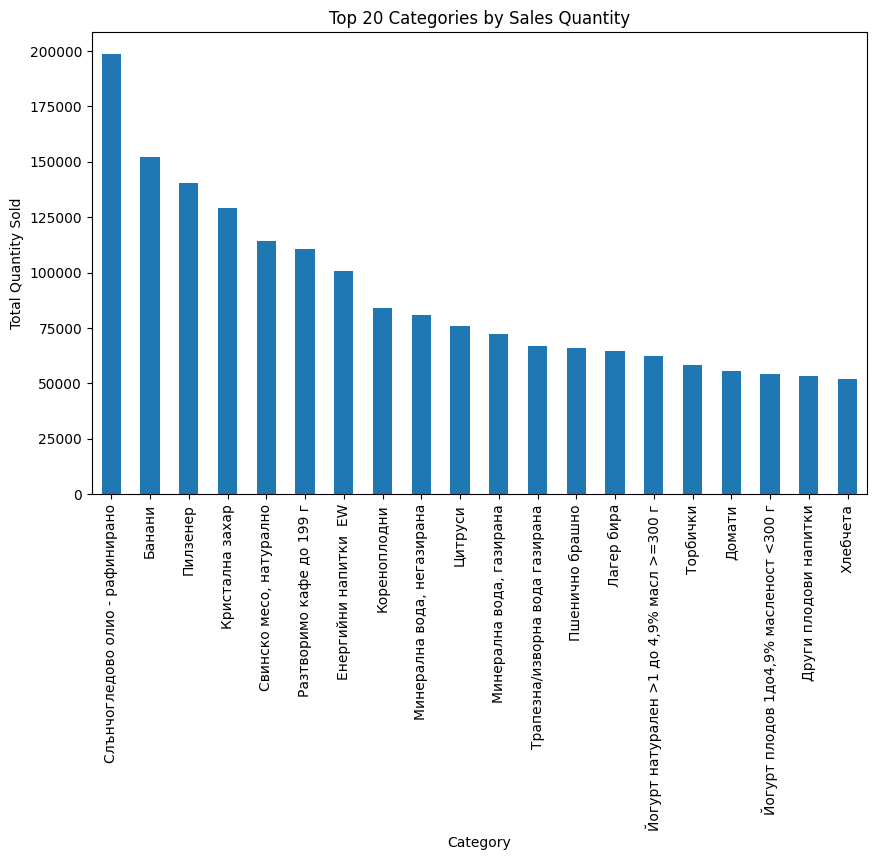

In [ ]:
# Top 20 categories by sales quantity
top_categories = data_cleaned.groupby('WGI_DESCRIPTION')['qty'].sum().nlargest(20)
plt.figure(figsize=(10, 6))
top_categories.plot(kind='bar')
plt.title('Top 20 Categories by Sales Quantity')
plt.xlabel('Category')
plt.ylabel('Total Quantity Sold')
plt.show()


### Customer spending categories

In [ ]:
# Categorizing the spending
def categorize_spending(price):
    if price < 50:
        return 'Low (< 50 lv)'
    elif price < 150:
        return 'Medium (< 150 lv)'
    elif price < 500:
        return 'High (< 500 lv)'
    else:
        return 'Very High (> 500 lv)'



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
customer_spending = data_cleaned.groupby(['customer', 'bon_id'])['price'].sum().reset_index()
customer_spending['category'] = data_cleaned['price'].apply(categorize_spending)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


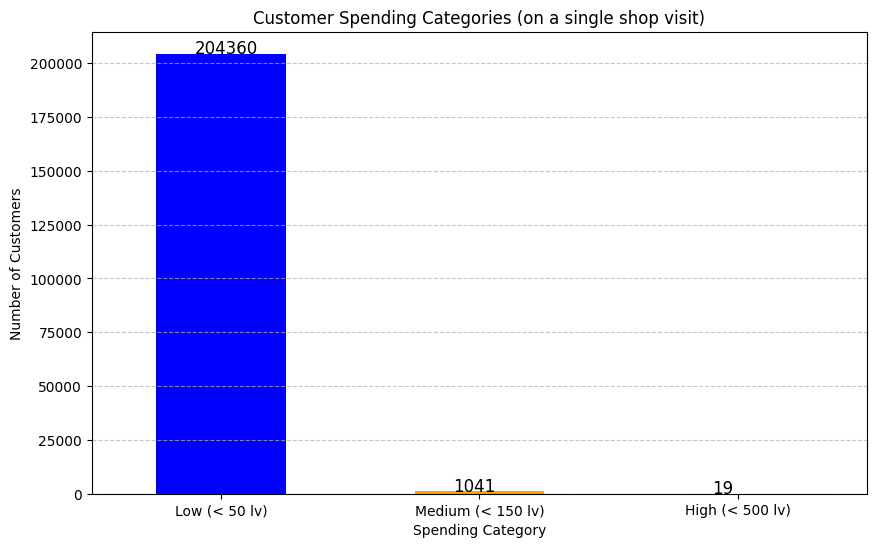

In [ ]:
# Creating a bar plot for the spending categories with counts on top of each bar
plt.figure(figsize=(10, 6))
category_counts = customer_spending['category'].value_counts()
bars = category_counts.plot(kind='bar', color=['blue', 'orange', 'green', 'red'])

plt.title('Customer Spending Categories (on a single shop visit)')
plt.xlabel('Spending Category')
plt.ylabel('Number of Customers')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adding the count numbers on top of each bar
for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1,
             bar.get_height() + 0.1,
             int(bar.get_height()),
             fontsize=12)

# Display the plot
plt.show()


In [23]:
# Categorizing the spending
def categorize_spending_total(price):
    if price < 100:
        return 'Low (< 100 lv)'
    elif price < 500:
        return 'Medium (< 500 lv)'
    elif price < 1000:
        return 'High (< 1000 lv)'
    else:
        return 'Very High (> 1000 lv)'

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


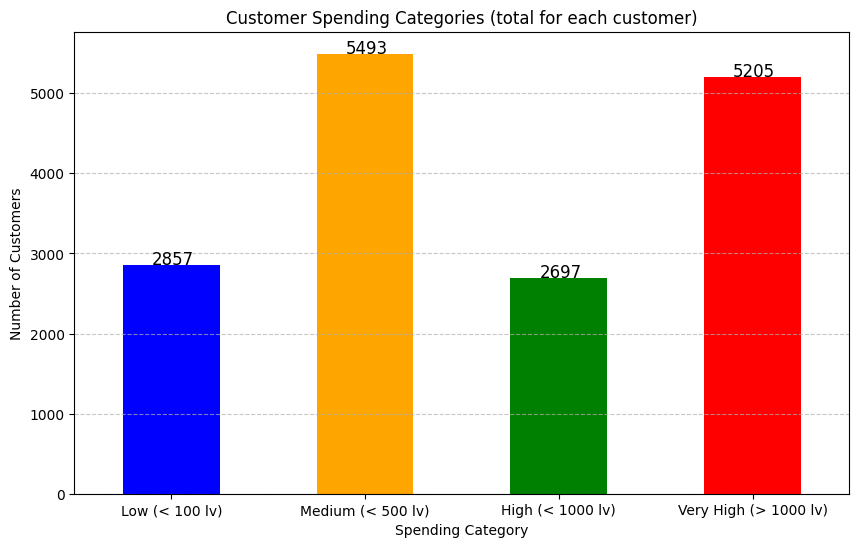

In [26]:
# Calculate total spending per customer
customer_spending_total = data_cleaned.groupby('customer')['price'].sum().reset_index()
customer_spending_total['category'] = customer_spending_total['price'].apply(categorize_spending_total)

# Create a bar plot for the spending categories with counts on top of each bar
plt.figure(figsize=(10, 6))
category_counts = customer_spending_total['category'].value_counts().reindex([
    'Low (< 100 lv)', 'Medium (< 500 lv)', 'High (< 1000 lv)', 'Very High (> 1000 lv)'
])
bars = category_counts.plot(kind='bar', color=['blue', 'orange', 'green', 'red'])

plt.title('Customer Spending Categories (total for each customer)')
plt.xlabel('Spending Category')
plt.ylabel('Number of Customers')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adding the count numbers on top of each bar
for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1,
             bar.get_height() + 0.1,
             int(bar.get_height()),
             fontsize=12)

# Display the plot
plt.show()

### Number of visits

In [5]:
# Group by customer and bon_id to count number of visits per customer
visit_counts = data_cleaned.groupby(['customer', 'bon_id']).size().reset_index(name='visit_count')

# Count the number of unique bon_ids per customer to get the number of visits
visits_per_customer = visit_counts.groupby('customer').size().reset_index(name='num_visits')

# Count the number of customers for each number of visits
visits_distribution = visits_per_customer['num_visits'].value_counts().sort_index()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
# Bin the number of visits
bins = [0, 4, 9, 49, 99, float('inf')]
labels = ['<5 visits', ' 5=< visits <10', '10=< visits <50', '50=< visits <100', '>=100 visits']
visits_per_customer['visit_bin'] = pd.cut(visits_per_customer['num_visits'], bins=bins, labels=labels, right=False)

# Count the number of customers in each bin
visits_distribution = visits_per_customer['visit_bin'].value_counts().sort_index()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


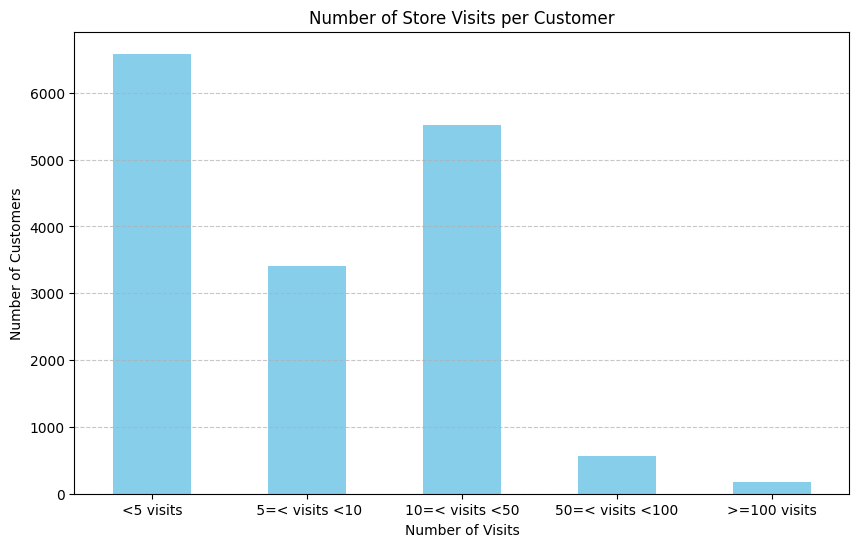

In [22]:
# Plot the results
plt.figure(figsize=(10, 6))
visits_distribution.plot(kind='bar', color='skyblue')
plt.title('Number of Store Visits per Customer')
plt.xlabel('Number of Visits')
plt.ylabel('Number of Customers')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.show()

### Monthly sales trends

C:\Users\Militsa\AppData\Local\Temp\ipykernel_1248\1459309236.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = data_cleaned['qty'].resample('M').sum()


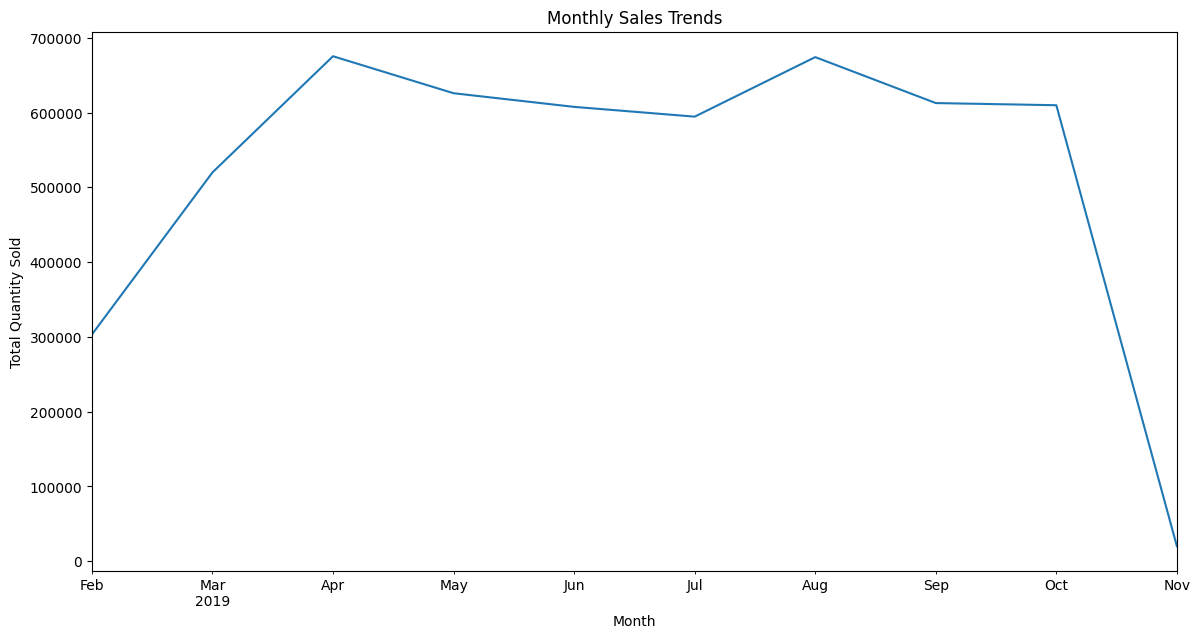

In [ ]:
data_cleaned['date_time'] = pd.to_datetime(data_cleaned['date_time'])
data_cleaned.set_index('date_time', inplace=True)

# Resample sales data by month
monthly_sales = data_cleaned['qty'].resample('ME').sum()
plt.figure(figsize=(14, 7))
monthly_sales.plot()
plt.title('Monthly Sales Trends')
plt.xlabel('Month')
plt.ylabel('Total Quantity Sold')
plt.show()


### Correlation between price and quantity

In [ ]:
# Analyze the relationship between price and quantity sold
price_qty_corr = data_cleaned[['price', 'qty']].corr()
print(price_qty_corr)


          price       qty
price  1.000000 -0.104357
qty   -0.104357  1.000000


### Basket analysis
Perform market basket analysis to identify items that are frequently bought together.

In [ ]:
# Sample a subset of the data (e.g., 5%)
sample_data = data_cleaned.sample(frac=0.05, random_state=1)


In [ ]:
sample_data.shape

(131212, 10)

In [ ]:
# Create the binary basket representation
basket = sample_data.groupby(['bon_id', 'WGI_DESCRIPTION'])['qty'].sum().unstack().reset_index().fillna(0).set_index('bon_id')
binary_basket = basket.map(lambda x: 1 if x > 0 else 0)


In [ ]:
# Check if any value in the entire DataFrame is 1
has_ones = (binary_basket.values == 1).any()

print(f"Any 1s in the binary_basket DataFrame: {has_ones}")


Any 1s in the binary_basket DataFrame: True


In [ ]:
# Compute the co-occurrence matrix
co_occurrence_matrix = binary_basket.T.dot(binary_basket)

In [ ]:
# Display the co-occurrence matrix
print(co_occurrence_matrix.head(10))

WGI_DESCRIPTION                Bisquits/ Menringues/Brownies  \
WGI_DESCRIPTION                                                
Bisquits/ Menringues/Brownies                            128   
Cafissimo капсули                                          0   
DVD-записи                                                 0   
Dolce Gusto капсули                                        0   
Halloween/ захарни изделия                                 0   
IPA Индийски Pale Ale                                      0   
Kaffeweisser                                               1   
Kупи                                                       0   
LED лампи                                                  1   
Nespresso капсули                                          0   

WGI_DESCRIPTION                Cafissimo капсули  DVD-записи  \
WGI_DESCRIPTION                                                
Bisquits/ Menringues/Brownies                  0           0   
Cafissimo капсули                      

In [ ]:
# Extract item pairs with high co-occurrence
import numpy as np

# Threshold for high co-occurrence
threshold = 20

# Find item pairs with co-occurrence above the threshold
item_pairs = np.where(co_occurrence_matrix > threshold)

# Extract the item pairs and their co-occurrence counts
item_pairs_with_counts = [(basket.columns[i], basket.columns[j], co_occurrence_matrix.iloc[i, j])
                          for i, j in zip(*item_pairs) if i != j]

# Display the item pairs with high co-occurrence
item_pairs_with_counts[:20]  # Display the top 20 pairs


[('SB Пилешка карантия', 'SB Пилешки разфасовки с кост', 22),
 ('SB Пилешка карантия', 'SB Пилешко филе', 23),
 ('SB Пилешки разфасовки с кост', 'SB Пилешка карантия', 22),
 ('SB Пилешки разфасовки с кост', 'SB Пилешко филе', 47),
 ('SB Пилешки разфасовки с кост', 'Банани', 33),
 ('SB Пилешки разфасовки с кост', 'Кореноплодни', 36),
 ('SB Пилешки разфасовки с кост', 'Пилзенер', 22),
 ('SB Пилешки разфасовки с кост', 'Свинско месо, натурално', 42),
 ('SB Пилешки разфасовки с кост', 'Слънчогледово олио - рафинирано', 24),
 ('SB Пилешки разфасовки с кост', 'Торбички', 22),
 ('SB Пилешки разфасовки с кост', 'Цитруси', 22),
 ('SB Пилешко филе', 'SB Пилешка карантия', 23),
 ('SB Пилешко филе', 'SB Пилешки разфасовки с кост', 47),
 ('SB Пилешко филе', 'Банани', 23),
 ('SB Пилешко филе', 'Домати', 24),
 ('SB Пилешко филе', 'Кореноплодни', 28),
 ('SB Пилешко филе', 'Свинско месо, натурално', 44),
 ('SB Пилешко филе', 'Слънчогледово олио - рафинирано', 39),
 ('SB Пилешко филе', 'Торбички', 26),


In [ ]:
# Filter unique item pairs
unique_item_pairs = set()
for item1, item2, count in item_pairs_with_counts:
    # Ensure consistent order (item1, item2)
    if item1 < item2:
        unique_item_pairs.add((item1, item2, count))
    else:
        unique_item_pairs.add((item2, item1, count))

# Convert the set to a list and sort by the number of occurrences
sorted_unique_item_pairs = sorted(list(unique_item_pairs), key=lambda x: x[2], reverse=True)

# Display the sorted unique item pairs
print(sorted_unique_item_pairs[:50])  # Display the top 50 unique pairs of items frequently both together

[('Банани', 'Кореноплодни', 67), ('Кореноплодни', 'Цитруси', 50), ('Банани', 'Цитруси', 47), ('SB Пилешки разфасовки с кост', 'SB Пилешко филе', 47), ('SB Пилешко филе', 'Свинско месо, натурално', 44), ('Кореноплодни', 'Слънчогледово олио - рафинирано', 43), ('SB Пилешки разфасовки с кост', 'Свинско месо, натурално', 42), ('Банани', 'Торбички', 41), ('Кореноплодни', 'Чушки', 40), ('Кореноплодни', 'Торбички', 39), ('Торбички', 'Цитруси', 39), ('SB Пилешко филе', 'Слънчогледово олио - рафинирано', 39), ('Кореноплодни', 'Свинско месо, натурално', 38), ('SB Пилешки разфасовки с кост', 'Кореноплодни', 36), ('Кореноплодни', 'Лукови', 36), ('Семкови плодове', 'Цитруси', 35), ('SB Пилешки разфасовки с кост', 'Банани', 33), ('Домати', 'Кореноплодни', 33), ('Кореноплодни', 'Семкови плодове', 32), ('Банани', 'Семкови плодове', 32), ('Свинско месо, натурално', 'Слънчогледово олио - рафинирано', 31), ('Домати', 'Краставици', 31), ('Домати', 'Чушки', 31), ('Кореноплодни', 'Маслини, пълнени', 30), ('

In [ ]:
#Calculate the correlation matrix

# Compute the correlation matrix for the binary data
correlation_matrix = binary_basket.corr()

# Display the correlation matrix
print(correlation_matrix.head())


WGI_DESCRIPTION                Bisquits/ Menringues/Brownies  \
WGI_DESCRIPTION                                                
Bisquits/ Menringues/Brownies                       1.000000   
Cafissimo капсули                                  -0.000610   
DVD-записи                                         -0.000130   
Dolce Gusto капсули                                -0.000651   
Halloween/ захарни изделия                         -0.000412   

WGI_DESCRIPTION                Cafissimo капсули  DVD-записи  \
WGI_DESCRIPTION                                                
Bisquits/ Menringues/Brownies          -0.000610   -0.000130   
Cafissimo капсули                       1.000000   -0.000054   
DVD-записи                             -0.000054    1.000000   
Dolce Gusto капсули                    -0.000270   -0.000057   
Halloween/ захарни изделия             -0.000171   -0.000036   

WGI_DESCRIPTION                Dolce Gusto капсули  \
WGI_DESCRIPTION                                 

In [ ]:
import numpy as np

# Extract the upper triangle of the correlation matrix
upper_tri = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))


WGI_DESCRIPTION                           WGI_DESCRIPTION                    
Unisex шал/кърпи/вратовръзки              Дамски шал, кърпи, др.                 0.707103
                                          Блокирана Дамски шал, кърпи, др.       0.707103
Индийско орехче                           Ликьор от цитрусови плодове            0.499991
Детски градински чехли                    Мъжки жилетки                          0.447203
Дамски пуловери/суитшърти                 Дамски ризи/блузи                      0.377951
Мъжко работно облекло                     Пътнически чанти/Раници                0.353533
Пица 4 сирена                             Пица Специале                          0.353533
Апарат-грижа за здравето (кр. налягане)   Електрически кани за вода              0.333310
Какаови, ядкови напитки                   Шунка от птиче месо                    0.316204
Вина от европейски общности               Сангрия                                0.301494
Висяща декорация      

In [ ]:
# Find the top 15 highest positive correlations
top_positive_correlations = upper_tri.stack().nlargest(30)

# Display the top correlations
print(top_positive_correlations)


WGI_DESCRIPTION                          WGI_DESCRIPTION                         
Unisex шал/кърпи/вратовръзки             Дамски шал, кърпи, др.                      0.707103
                                         Блокирана Дамски шал, кърпи, др.            0.707103
Индийско орехче                          Ликьор от цитрусови плодове                 0.499991
Детски градински чехли                   Мъжки жилетки                               0.447203
Дамски пуловери/суитшърти                Дамски ризи/блузи                           0.377951
Мъжко работно облекло                    Пътнически чанти/Раници                     0.353533
Пица 4 сирена                            Пица Специале                               0.353533
Апарат-грижа за здравето (кр. налягане)  Електрически кани за вода                   0.333310
Какаови, ядкови напитки                  Шунка от птиче месо                         0.316204
Вина от европейски общности              Сангрия                        

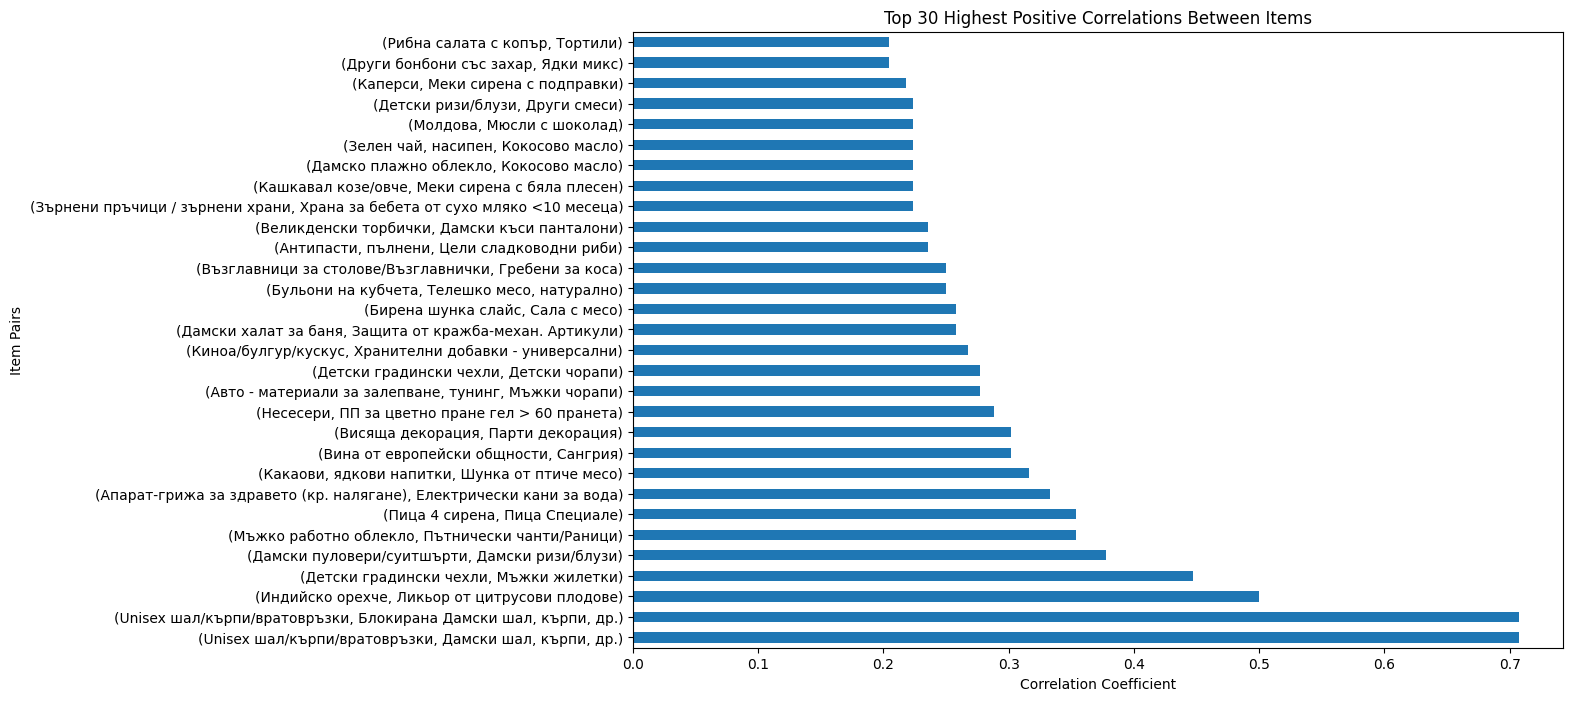

In [ ]:
import matplotlib.pyplot as plt

# Plot the top 30 highest positive correlations
plt.figure(figsize=(12, 8))
top_positive_correlations.plot(kind='barh')
plt.title('Top 30 Highest Positive Correlations Between Items')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Item Pairs')
plt.show()


In [ ]:
import pandas as pd

# Check the number of unique WGI_DESCRIPTIONS
unique_wgi_descriptions = data_cleaned['WGI_DESCRIPTION'].nunique()

print(f'The number of unique WGI_DESCRIPTION values is: {unique_wgi_descriptions}')


The number of unique WGI_DESCRIPTION values is: 1608


## Modeling and recommendation engine using BERT

An option we considered was to create a recommendation engine using SpaCy, but we decided to use BERT - a leading-edge natural language processing model. BERT’s main innovation is its ability to understand the context of a word in a sentence by looking at the words that come before and after it. This bidirectional approach allows BERT to capture the meaning of words more accurately than previous models, which typically processed text in a unidirectional manner (left-to-right or right-to-left). Our goal is to leverage BERT’s advanced capabilities to enhance the relevance and accuracy of recommendations based on textual descriptions of items.


In [ ]:
import pandas as pd

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from google.colab import drive 
drive.mount('/content/drive')


Mounted at /content/drive


### Embeddings using only the WGI column from 'wgi_descriptions.csv'

In [ ]:
import pandas as pd
data = pd.read_csv('wgi_descriptions.csv')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Load the dataset
sample_data = data.copy()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
unique_wgi_descriptions = sample_data['WGI_DESCRIPTION'].unique()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
len(unique_wgi_descriptions) #1609

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1609

In [ ]:
import torch
from transformers import BertTokenizer, BertModel #Loading the pre-trained BERT multilingual model

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Load the multilingual BERT model and tokenizer
model_name = "bert-base-multilingual-cased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

In [ ]:
# Function to get BERT embeddings (vectorization of the words)
def get_embeddings(text, tokenizer, model):
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Get embeddings for each item in the DataFrame
embeddings = sample_data['WGI_DESCRIPTION'].apply(lambda x: get_embeddings(x, tokenizer, model)).tolist()
embeddings_matrix = torch.stack(embeddings).numpy()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Load already generated embeddings

In [ ]:
# Load embeddings and embeddings matrix from Google Drive. These are the ebeddings that I have generated with the code above and have saved in Drive; 
embeddings_path = 'embeddings.pkl'
embeddings_matrix_path = 'embeddings_matrix.pkl'

with open(embeddings_path, 'rb') as f:
    embeddings = pickle.load(f)

with open(embeddings_matrix_path, 'rb') as f:
    embeddings_matrix = pickle.load(f)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Function to recommend items based on a description
def recommend_items(input_description, embeddings_matrix, sample_data, tokenizer, model, top_n=10):
    input_embedding = get_embeddings(input_description, tokenizer, model).unsqueeze(0).numpy()
    similarities = cosine_similarity(input_embedding, embeddings_matrix).flatten()

    # Create a DataFrame to store similarities and descriptions
    similarity_df = pd.DataFrame({
        'WGI_DESCRIPTION': sample_data['WGI_DESCRIPTION'],
        'similarity': similarities
    })

    # Sort by similarity in descending order and drop duplicates
    unique_recommendations = similarity_df.sort_values(by='similarity', ascending=False).drop_duplicates('WGI_DESCRIPTION')

    # Select top N recommendations
    top_recommendations = unique_recommendations.head(top_n)

    return top_recommendations

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Get recommendations

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Example usage
input_description = sample_data['WGI_DESCRIPTION'].iloc[39] #use either this
#input_description='Вода' # or this, not both
print(f'Input item: {input_description}')
recommended_items = recommend_items(input_description, embeddings_matrix, sample_data, tokenizer, model)
print(recommended_items)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Input item: Кърпи за почистване
                       WGI_DESCRIPTION  similarity
4311               Кърпи за почистване    1.000000
5824                     Кърпи за прах    0.866059
4259   Кърпички за почистване на очила    0.865328
22778   Кърпички за почистване на лице    0.833138
21226               Картофи за пържене    0.824234
16195                    Конци за зъби    0.795469
19675              Козметични кърпички    0.785511
4376                      Крем за ръце    0.777325
8515                Пликчета за фризер    0.776784
12084             Почистване на мебели    0.765757


## Evaluation

We are evaluating the recommendation engine by comparing the recommended products to the actual products purchased by customers on their subsequent visits. Initially, we identify customers who have made more than one purchase (bon_id) and split their purchase history into two dataframes: input_df (first visit) and test_df (second visit). For a random sample of 100 customers, we generate product recommendations based on their first visit's purchases and compare these recommendations (the top 5 recommendations) to the products they bought on their second visit. The success rate is calculated by determining the proportion of recommended products that match the actual purchased products, both for each customer and overall. The results are printed, showing the success rate for each customer and the overall success rate.


In [ ]:
# Group by customer and bon_id
grouped = data_cleaned.groupby(['customer', 'bon_id']).agg({'date_time': 'min', 'price': 'sum'}).reset_index()

# Find customers with more than one bon_id
customer_counts = grouped['customer'].value_counts()
customers_with_multiple_bon_ids = customer_counts[customer_counts > 1].index.tolist()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
grouped.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,customer,bon_id,date_time,price
0,0005999f1ed76cced979,9ItjtcoB1at0V41f8JSLog,2019-04-06 19:49:25,24.84
1,0005999f1ed76cced979,OgsrGkqUzXrJREXKbJ7lwQ,2019-03-16 19:26:24,67.20
2,0005999f1ed76cced979,QnPLXJs0nLokp7sU1GtOdg,2019-04-10 19:04:56,94.38
3,0005999f1ed76cced979,cgoqoZHHUXw2QLLDlwmd4w,2019-04-06 19:51:15,56.86
4,0005999f1ed76cced979,h+pUWVnaLS9D7OZtVPPjag,2019-03-16 19:28:04,91.68


In [ ]:
data_cleaned[data_cleaned['customer'] == '0005999f1ed76cced979']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,bon_id,customer,article_id,price,qty,unit,article_mother,wgi,date_time,WGI_DESCRIPTION
510471,j/O7LlV9NIPPmjQboxAvDQ,0005999f1ed76cced979,46390,1.75,1.0,ST,46386,588002,2019-04-21 08:54:11,Мокра котешка храна консерва малка
510849,j/O7LlV9NIPPmjQboxAvDQ,0005999f1ed76cced979,46386,1.75,1.0,ST,46386,588002,2019-04-21 08:54:11,Мокра котешка храна консерва малка
512107,j/O7LlV9NIPPmjQboxAvDQ,0005999f1ed76cced979,102503,12.29,1.0,ST,102504,638002,2019-04-21 08:54:11,Деоспрей мъжки с пулверизатор
512944,j/O7LlV9NIPPmjQboxAvDQ,0005999f1ed76cced979,59097,12.59,1.0,ST,0,589002,2019-04-21 08:54:11,"Суха котешка храна, голяма"
513936,j/O7LlV9NIPPmjQboxAvDQ,0005999f1ed76cced979,61039,2.99,1.0,ST,61039,586005,2019-04-21 08:54:11,"Суха кучешка храна, снакс"
...,...,...,...,...,...,...,...,...,...,...
2508677,QnPLXJs0nLokp7sU1GtOdg,0005999f1ed76cced979,21081,1.98,1.0,ST,0,163012,2019-04-10 19:04:56,Салати и листни зеленчуци
2509214,QnPLXJs0nLokp7sU1GtOdg,0005999f1ed76cced979,3901851,1.89,1.0,ST,0,435002,2019-04-10 19:04:56,Оцет
2510538,QnPLXJs0nLokp7sU1GtOdg,0005999f1ed76cced979,2302102,5.99,1.0,ST,2300577,538003,2019-04-10 19:04:56,Оранжада
2510773,QnPLXJs0nLokp7sU1GtOdg,0005999f1ed76cced979,13177,2.49,1.0,ST,0,156002,2019-04-10 19:04:56,Хляб


In [ ]:
# Filter data to include only those customers
filtered_grouped = grouped[grouped['customer'].isin(customers_with_multiple_bon_ids)]

# Sort by customer and date_time in ascending order
sorted_grouped = filtered_grouped.sort_values(by=['customer', 'date_time'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
sorted_grouped.head(10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,customer,bon_id,date_time,price
1,0005999f1ed76cced979,OgsrGkqUzXrJREXKbJ7lwQ,2019-03-16 19:26:24,67.20
4,0005999f1ed76cced979,h+pUWVnaLS9D7OZtVPPjag,2019-03-16 19:28:04,91.68
0,0005999f1ed76cced979,9ItjtcoB1at0V41f8JSLog,2019-04-06 19:49:25,24.84
3,0005999f1ed76cced979,cgoqoZHHUXw2QLLDlwmd4w,2019-04-06 19:51:15,56.86
2,0005999f1ed76cced979,QnPLXJs0nLokp7sU1GtOdg,2019-04-10 19:04:56,94.38
5,0005999f1ed76cced979,j/O7LlV9NIPPmjQboxAvDQ,2019-04-21 08:54:11,34.34
12,0005c7a9975193b7c564,cnAS91hMKQqJsKaPbQOSlg,2019-06-15 08:52:18,68.97
8,0005c7a9975193b7c564,Cn2cHmbsdbb8h9dIXm4MDA,2019-06-25 16:32:01,72.41
11,0005c7a9975193b7c564,RfWAW5r9du9/71DhZYlubQ,2019-07-06 09:12:26,57.20
16,0005c7a9975193b7c564,n4nck2r151RIHUdgtoctzg,2019-07-14 09:41:57,58.18


In [ ]:
# Create auxiliary table
auxiliary_table = sorted_grouped[['customer', 'bon_id', 'date_time']]

# Split into input_df (first visit) and test_df (second visit)
first_visits = auxiliary_table.groupby('customer').nth(0).reset_index()
second_visits = auxiliary_table.groupby('customer').nth(1).reset_index()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Ensure both dataframes have the same length
input_df = first_visits[first_visits['customer'].isin(second_visits['customer'])].reset_index(drop=True)
test_df = second_visits[second_visits['customer'].isin(first_visits['customer'])].reset_index(drop=True)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Take 100 random customers from each dataframe
random_customers = np.random.choice(input_df['customer'], size=100, replace=False)

input_df_sample = input_df[input_df['customer'].isin(random_customers)].reset_index(drop=True)
test_df_sample = test_df[test_df['customer'].isin(random_customers)].reset_index(drop=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
input_df_sample

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,index,customer,bon_id,date_time
0,6933,07d64112d5eecadef333,fPe3irubrpuisoslCIN+UA,2019-04-30 14:43:44
1,7586,08855d364aaaa8caa838,4BPK0FljyfxziQ4ceCKT5A,2019-04-14 10:15:22
2,8259,0973c963ced02f7f6ef4,wZmtqmmRdPYGiYX+P4eRpA,2019-04-19 10:51:32
3,9597,0b11092224b5f776b035,iEpRyK848VXZ0aCYepAjuA,2019-07-08 13:37:37
4,16359,125d957974b46cb0caff,sr6s88wwRW3rrUaAVIzSFg,2019-07-12 17:56:44
...,...,...,...,...
95,195097,f3998455b2237d73de49,PQ4rHg3LTkeGp0HMSNN6SA,2019-09-29 17:49:07
96,195265,f3c5808af33cc911d411,N2X97wxwHGwzVf3cPpFTZg,2019-03-13 09:55:55
97,197942,f677d1e47724ba7582c9,ZFtwUvl4DPLVmDBHY/ESzA,2019-02-22 14:07:47
98,204326,fe87f737fae21ed2d8e8,5YJ8ShuPK5FEkB7/m31mpA,2019-04-30 12:34:45


In [ ]:
test_df_sample

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,index,customer,bon_id,date_time
0,6930,07d64112d5eecadef333,3nlksz1N+/o+oc5Guuqa0Q,2019-05-06 12:52:20
1,7612,08855d364aaaa8caa838,qbXNRtGiuz3T1/amoBmuFA,2019-04-21 10:38:12
2,8249,0973c963ced02f7f6ef4,HZu39HtMjYw1hZ9732IPRQ,2019-04-19 10:52:20
3,9595,0b11092224b5f776b035,6pGf9RdR1NUTHKcseQEZog,2019-08-02 13:29:00
4,16357,125d957974b46cb0caff,X7ztwh2vqUCdkx7owoqoLg,2019-08-12 17:32:14
...,...,...,...,...
95,195099,f3998455b2237d73de49,bP2T5V3KBMc9yRetD/V/nw,2019-09-29 17:50:24
96,195271,f3c5808af33cc911d411,vDlXod0P6hqBh7cUi6w3EA,2019-03-13 09:56:36
97,197908,f677d1e47724ba7582c9,4bY4mr4wn7ySfXw2W1nJeA,2019-02-24 16:54:31
98,204328,fe87f737fae21ed2d8e8,rn2jG7lefAUyvQz1rteIUw,2019-05-23 16:06:40


In [ ]:
success_counts = []
test_products_count=[]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
for _, input_row in input_df_sample.iterrows():
    customer = input_row['customer']
    input_bon_id = input_row['bon_id']

    # Extract purchased products for the given customer and bon_id from data_cleaned
    input_products = data_cleaned[(data_cleaned['customer'] == customer) & (data_cleaned['bon_id'] == input_bon_id)]['WGI_DESCRIPTION']

    customer_success_count = 0
    customer_total_recommendations = 0

    for product in input_products:
        top_recommendations = recommend_items(product, embeddings_matrix, sample_data, tokenizer, model, top_n=5)
        recommended_products = top_recommendations['WGI_DESCRIPTION'].tolist()

        # Get test products for the customer from test_df_sample
        test_bon_id = test_df_sample[test_df_sample['customer'] == customer]['bon_id'].values[0]
        test_products = data_cleaned[(data_cleaned['customer'] == customer) & (data_cleaned['bon_id'] == test_bon_id)]['WGI_DESCRIPTION']

        # Check for successful recommendations
        successful_recommendations = set(recommended_products).intersection(set(test_products))
        customer_success_count += len(successful_recommendations)
        customer_total_recommendations += len(recommended_products)

    success_rate = customer_success_count / len(test_products) if len(test_products) > 0 else 0
    success_counts.append(success_rate)
    test_products_count.append(len(test_products))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Overall success rate

In [ ]:
# Calculate overall success rate
overall_success_rate = sum(success_counts) / len(success_counts) if success_counts else 0

print("Overall Success Rate:", overall_success_rate) #Overall Success Rate: 0.3113482565852801

Overall Success Rate: 0.3113482565852801


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Success rates for all individual test customers

In [ ]:
for i in range (len(success_counts)):
  print(f'Success rate customer # {i}: {success_counts[i]} / Number of products: {test_products_count[i]}')



Success rate customer # 0: 0.30303030303030304 / Number of products: 33
Success rate customer # 1: 0.1 / Number of products: 10
Success rate customer # 2: 0.25 / Number of products: 4
Success rate customer # 3: 0.18181818181818182 / Number of products: 11
Success rate customer # 4: 0.8333333333333334 / Number of products: 6
Success rate customer # 5: 0.12121212121212122 / Number of products: 33
Success rate customer # 6: 0.625 / Number of products: 8
Success rate customer # 7: 0.4 / Number of products: 5
Success rate customer # 8: 0.3333333333333333 / Number of products: 6
Success rate customer # 9: 0.0 / Number of products: 9
Success rate customer # 10: 0.3333333333333333 / Number of products: 9
Success rate customer # 11: 1.0 / Number of products: 2
Success rate customer # 12: 0.0 / Number of products: 2
Success rate customer # 13: 0.0 / Number of products: 6
Success rate customer # 14: 0.08333333333333333 / Number of products: 12
Success rate customer # 15: 0.4 / Number of products:

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
